## Setup

In [ ]:
!pip install fastai
!pip install transformers==2.5.1
!pip install datasets
!pip install sentencepiece

     |████████████████████████████████| 499 kB 10.9 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
     |████████████████████████████████| 131 kB 48.7 MB/s 
     |████████████████████████████████| 5.6 MB 10.8 MB/s 
     |████████████████████████████████| 1.2 MB 24.9 MB/s 
     |████████████████████████████████| 8.1 MB 35.1 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 138 kB 48.0 MB/s 
     |████████████████████████████████| 127 kB 55.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 290 kB 12.7 MB

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
import transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig

#PAWS dataset
from datasets import load_dataset

from sklearn.metrics import accuracy_score,f1_score

## Getting Data

In [ ]:
dataset = load_dataset("paws-x","en")

train_df = pd.DataFrame(data=dataset['train'][:])
validation_df = pd.DataFrame(data=dataset['validation'][:])
test_df = pd.DataFrame(data=dataset['test'][:])

Downloading:   0%|          | 0.00/2.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/30.3M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset pawsx downloaded and prepared to /root/.cache/huggingface/datasets/pawsx/en/1.1.0/a5033b43902a02a4ba2ee469c1dd22af3e6a4a247ac47fa1af9835d0e734e2af. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(f"Number of Training records = {len(train_df)}")
print(f"Number of Test records = {len(test_df)}")

Number of Training records = 49401
Number of Test records = 2000


In [ ]:
train_df.head()

,id,sentence1,sentence2,label
0,1,"In Paris , in October 1560 , he secretly met t...","In October 1560 , he secretly met with the Eng...",0
1,2,The NBA season of 1975 -- 76 was the 30th seas...,The 1975 -- 76 season of the National Basketba...,1
2,3,"There are also specific discussions , public p...","There are also public discussions , profile sp...",0
3,4,When comparable rates of flow can be maintaine...,The results are high when comparable flow rate...,1
4,5,It is the seat of Zerendi District in Akmola R...,It is the seat of the district of Zerendi in A...,1


## XLNET Class

In [ ]:
model_type = 'xlnet'
pretrained_model_name = 'xlnet-base-cased'

In [ ]:
MODEL_CLASS = {    
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
}
model_class, tokenizer_class, config_class = MODEL_CLASS[model_type]

In [ ]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['xlnet-base-cased', 'xlnet-large-cased'])

## Util Function

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed = 42
seed_all(seed)

## Custom Tokenizer 

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):

    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type , **kwargs):

        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""

        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        
        tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        if self.model_type in ['xlnet']:
            tokens = tokens + [SEP] +  [CLS]
      
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
print(transformer_tokenizer)

transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

## Custom Numericalizer

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

## Custom Processor

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
use_fp16 = False
bs = 16

databunch = (TextList.from_df(train_df, cols=['sentence1','sentence2'], processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(validation_df)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
databunch

TextClasDataBunch;

Train: LabelList (44461 items)
x: TextList
▁In ▁Paris ▁ , ▁in ▁October ▁15 60 ▁ , ▁he ▁secretly ▁met ▁the ▁English ▁ambassador ▁ , ▁Nicolas ▁Th rock mor ton ▁ , ▁asking ▁him ▁for ▁a ▁passport ▁to ▁return ▁to ▁England ▁through ▁Scotland ▁ . ▁In ▁October ▁15 60 ▁ , ▁he ▁secretly ▁met ▁with ▁the ▁English ▁ambassador ▁ , ▁Nicolas ▁Th rock mor ton ▁ , ▁in ▁Paris ▁ , ▁and ▁asked ▁him ▁for ▁a ▁passport ▁to ▁return ▁to ▁Scotland ▁through ▁England ▁ . <sep> <cls>,▁The ▁NBA ▁season ▁of ▁1975 ▁ - - ▁76 ▁was ▁the ▁30 th ▁season ▁of ▁the ▁National ▁Basketball ▁Association ▁ . ▁The ▁1975 ▁ - - ▁76 ▁season ▁of ▁the ▁National ▁Basketball ▁Association ▁was ▁the ▁30 th ▁season ▁of ▁the ▁NBA ▁ . <sep> <cls>,▁There ▁are ▁also ▁specific ▁discussions ▁ , ▁public ▁profile ▁debates ▁and ▁project ▁discussions ▁ . ▁There ▁are ▁also ▁public ▁discussions ▁ , ▁profile ▁specific ▁discussions ▁ , ▁and ▁project ▁discussions ▁ . <sep> <cls>,▁When ▁comparable ▁rates ▁of ▁flow ▁can ▁be ▁maintained ▁ 

## Custom Model

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

## Learner

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))


if use_fp16: learner = learner.to_fp16()

## Prediction

In [ ]:
def get_ordered_preds(learner, ds_type, with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None,
              ordered:bool=True) -> List[Tensor]:

    "Return predictions and targets on the valid, train, or test set, depending on `ds_type`."
    #FIXME: check if this is required. reset is done in fastai. implement if require for BERT also
    #learner.model.reset()
    learner.model.eval()
    if ordered: np.random.seed(42)
    preds = learner.get_preds(ds_type=ds_type, with_loss=with_loss, n_batch=n_batch, pbar=pbar)
    if ordered and hasattr(learner.dl(ds_type), 'sampler'):
        np.random.seed(42)
        sampler = [i for i in learner.dl(ds_type).sampler]
        reverse_sampler = np.argsort(sampler)
        preds = [p[reverse_sampler] for p in preds] 
    return(preds)

def get_predictions(learner, ds_type, with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None,
          ordered:bool=True):
    preds, true_labels =  get_ordered_preds(learner, ds_type=ds_type, with_loss=with_loss, n_batch=n_batch, pbar=pbar, ordered=ordered)
    pred_values = np.argmax(preds, axis=1)
    return preds, pred_values, true_labels

def print_metrics(learner, preds, pred_values, true_labels):
    acc = accuracy_score(pred_values, true_labels)
    f1s = f1_score(true_labels, pred_values)
    print(f"Accuracy={acc}, f1_score={f1s}")

In [ ]:
 preds, pred_values, true_labels = get_predictions(learner, DatasetType.Test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
print_metrics(learner, preds, pred_values, true_labels)

Accuracy=0.5175, f1_score=0.0


## Train

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	ad

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.31E-07


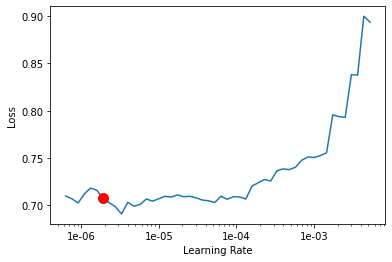

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.586868,0.610249,0.669028,0.330972,25:40
1,0.307644,0.279444,0.891093,0.108907,26:37
2,0.272397,0.269873,0.900000,0.100000,26:12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


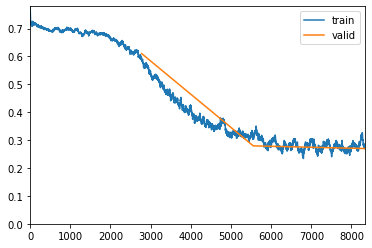

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged n

In [ ]:
learner.fit_one_cycle(3, max_lr=1.9e-6)

In [ ]:
learner.export(file = 'transformer.pkl')

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
def get_preds_as_nparray(learner, ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(learner, DatasetType.Test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
test_pred_values = np.argmax(test_preds,axis=1)

In [ ]:
eval_df = validation_df.copy()
eval_df = eval_df[['sentence1' , 'sentence2' , 'label']]
eval_df['Predicted Label'] = test_pred_values
eval_df


,sentence1,sentence2,label,Predicted Label
0,From the merger of the Four Rivers Council and...,Shawnee Trails Council was formed from the mer...,1,1
1,Kathy and her husband Pete Beale ( Peter Dean ...,Kathy and her husband Peter Dean ( Pete Beale ...,1,0
2,Timora diarhoda is a species of moth of the No...,Diarhoda is a kind of moth of the Noctuidae fa...,1,0
3,Joe R. Campa Jr. is a former sailor of the Uni...,Joe R. Campa Jr. is a former U.S. Navy Matrose...,1,1
4,"Cook Pond , also known as the South Watuppa Po...","Cook Pond , also formerly known as Laurel Lake...",0,0
...,...,...,...,...
1995,"Lee has played professionally in Italy , Russi...","He played professionally in Greece , Russia , ...",0,0
1996,Round Island is currently uninhabited and is o...,Round Island is currently uninhabited and is a...,0,0
1997,She is praised by Richard Gibson and the court...,She is praised by Richard Gibson and the court...,0,0
1998,"The JoyKey has no moving parts , no corks that...","The JoyKey has no moving parts , no corks that...",0,0


In [ ]:
correctly_labelled_df = eval_df[eval_df['label'] == eval_df['Predicted Label']]
correctly_labelled_df

,sentence1,sentence2,label,Predicted Label
0,From the merger of the Four Rivers Council and...,Shawnee Trails Council was formed from the mer...,1,1
3,Joe R. Campa Jr. is a former sailor of the Uni...,Joe R. Campa Jr. is a former U.S. Navy Matrose...,1,1
4,"Cook Pond , also known as the South Watuppa Po...","Cook Pond , also formerly known as Laurel Lake...",0,0
5,"The family moved to Camp Hill in 1972 , where ...","In 1972 , the family moved to Camp Hill , wher...",1,1
6,Components of elastic potential systems store ...,Components of elastic potential systems store ...,1,1
...,...,...,...,...
1995,"Lee has played professionally in Italy , Russi...","He played professionally in Greece , Russia , ...",0,0
1996,Round Island is currently uninhabited and is o...,Round Island is currently uninhabited and is a...,0,0
1997,She is praised by Richard Gibson and the court...,She is praised by Richard Gibson and the court...,0,0
1998,"The JoyKey has no moving parts , no corks that...","The JoyKey has no moving parts , no corks that...",0,0


In [ ]:
for _,row in list(correctly_labelled_df.iterrows())[:10]:
  print("SENTENCE 1 -> " , end="")
  print(row['sentence1'])

  print("SENTENCE 2 -> " , end="")
  print(row['sentence2'])

  print("PREDICTED = " , row['Predicted Label'] , "ACTUAL = " , row['label'])
  print("-------")
  print()

SENTENCE 1 -> From the merger of the Four Rivers Council and the Audubon Council , the Shawnee Trails Council was born .
SENTENCE 2 -> Shawnee Trails Council was formed from the merger of the Four Rivers Council and the Audubon Council .
PREDICTED =  1 ACTUAL =  1
-------

SENTENCE 1 -> Joe R. Campa Jr. is a former sailor of the United States Navy , who served as the eleventh Master Chief Petty Officer of the U.S. Navy .
SENTENCE 2 -> Joe R. Campa Jr. is a former U.S. Navy Matrose who served as the 11th Master Chief Petty Officer of the United States Navy .
PREDICTED =  1 ACTUAL =  1
-------

SENTENCE 1 -> Cook Pond , also known as the South Watuppa Pond , is located south east of Laurel Lake and west of the Taunton River .
SENTENCE 2 -> Cook Pond , also formerly known as Laurel Lake , is located south east of the Taunton River and west of the South Watuppa Pond .
PREDICTED =  0 ACTUAL =  0
-------

SENTENCE 1 -> The family moved to Camp Hill in 1972 , where he attended Trinity High Sc